# HW2 - A guided surrogate attack implementation (partial solution)

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/02/2024)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Pillow (tested on v9.3.0)
- Torch (tested on v1.13.0)
- Torchmetrics (tested on v0.11.0)

### 0. Prelim: Imports needed and testing for CUDA

In [1]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# Torchvision
from torchvision import datasets, transforms
# Our custom ResNet and utils functions
from resnet import *
from utils import *

We advise running on GPU and setting up CUDA on your machine as it might drastically speed up the running time for this notebook!

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### 1. Prelim: Dataset and Dataloader

The CIFAR-10 training dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.
We will only use 1000 samples for each class (to keep the dataset small in size and reduce the execution time), hence using 10000 samples in total.

In [3]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the CIFAR10 dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

In [4]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])

In [5]:
# CIFAR10 dataset and dataloader
# (Training set)
train_dataset = torchvision.datasets.CIFAR10(root = './data/', download = True, train = True, transform = tf)
train_dataset_reduced = torch.utils.data.Subset(train_dataset, [i for i in range(0, 10000)])
train_loader = torch.utils.data.DataLoader(dataset = train_dataset_reduced, batch_size = 256, shuffle = False)
print(len(train_loader))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [01:42<00:00, 1.67MB/s]


40


Similarly, the test set has 1000 images in each class, but for simplicity and reduced execution time, we will only use 20 images in each class to evaluate our attack functions (or 200 images in total).

In [6]:
# CIFAR10 dataset and dataloader
# (Testing set)
test_dataset = torchvision.datasets.CIFAR10(root = './data/', download = True, train = False, transform = tf)
test_dataset_reduced = torch.utils.data.Subset(test_dataset, [i for i in range(0, 200)])
test_loader = torch.utils.data.DataLoader(dataset = test_dataset_reduced, batch_size = 1, shuffle = False)
print(len(test_loader))

200


### 2. Prelim: Our pre-trained Model under attack

We will use a simple pre-trained resnet model, with architecture and trainer stored in *resnet.py* and weights stored in file *resnet.data*.
This is a pre-trained model with a simple architecture. Its baseline accuracy is 88.16%, and a rather easy target for an attack.

In [7]:
# Load the pretrained model
original_model = ResNet(ResidualBlock, [2, 2, 2])
pretrained_model = "./resnet.data"
original_model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
original_model.to(device)
original_model.eval()
print(original_model)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### 3. Writing our attack function

As shown below.

In [8]:
def iugm_attack(image, epsilon, model, original_label, iter_num = 10):
    # Skip if epsilon is 0
    if epsilon == 0:
        return image

    for _ in range(iter_num):
        # Zero out previous gradients
        image.grad = None

        # Forward pass
        output = model(image)

        # Get the index of the least probable class (min log-probability)
        _, target_class = torch.min(output.data, 1)

        # Calculate loss based on the least probable class
        pred_loss = F.nll_loss(output, target_class)

        # Backward pass and retain graph
        pred_loss.backward(retain_graph=True)

        # Gradient descent to the least probable class (target class)
        eps_image = image - epsilon * image.grad.data
        eps_image.retain_grad()

        # Clipping to maintain pixel values in the [0, 1] range
        eps_image = torch.clamp(eps_image, 0, 1)

        # Forward pass
        new_output = model(eps_image)

        # Get prediction
        _, new_label = new_output.data.max(1)

        # Check if label is different from the original, if so stop
        if new_label != original_label:
            break
        else:
            image = eps_image
            image.retain_grad()

    return eps_image

### 4. Testing your attack on your model

We will consider two different attack strategies (one-shot and iterated), with different epsilon values and numbers of maximal iterations 

#### First attack: one-shot untargeted gradient attack

If we fix max_iter = 1, we will make our iterated attack a one-shot attack.

#### Second attack: iterated untargeted gradient attack

We fix max_iter = 10.

In [8]:
# Test First attack: one-shot untargeted gradient attack
epsilons = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
accuracies, examples = run_attacks_for_epsilon(epsilons, \
                                               original_model, \
                                               iugm_attack, \
                                               device, \
                                               test_loader, \
                                               max_iter = 1)

NameError: name 'iugm_attack' is not defined

In [10]:
# Test Second attack: iterated untargeted gradient attack
epsilons2 = [0, 0.001, 0.002, 0.005, 0.01,  0.02, 0.05, 0.1, 0.2, 0.5]
accuracies2, examples2 = run_attacks_for_epsilon(epsilons2, \
                                                 original_model, \
                                                 iugm_attack, \
                                                 device, \
                                                 test_loader, \
                                                 max_iter = 10)

Epsilon: 0 - Model Accuracy (under attack) = 176/200 = 0.88
Epsilon: 0.001 - Model Accuracy (under attack) = 133/200 = 0.665
Epsilon: 0.002 - Model Accuracy (under attack) = 82/200 = 0.41
Epsilon: 0.005 - Model Accuracy (under attack) = 13/200 = 0.065
Epsilon: 0.01 - Model Accuracy (under attack) = 5/200 = 0.025
Epsilon: 0.02 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.05 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.1 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.2 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.5 - Model Accuracy (under attack) = 0/200 = 0.0


### 5. Visualization of attacks effects on pre-trained model 

As usual, we will display the accuracy vs. epsilon values graph for our given attack, as well as some samples for the given epsilon values.

The graph below will display the accuracy vs. epsilon value for both attacks.

We also suggest to show some adversarial examples, to compute the plausibility threshold value for $ \epsilon $, using the two cells below.

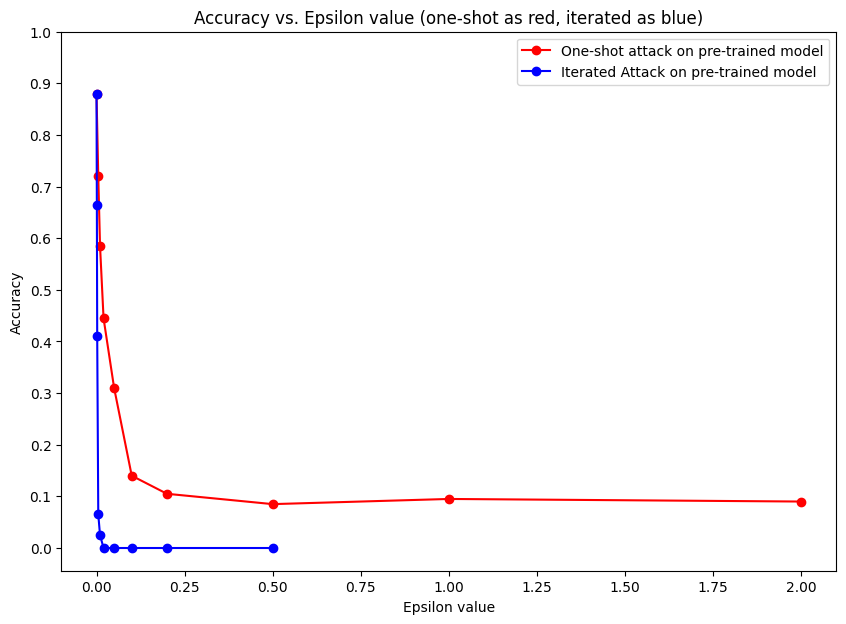

In [11]:
# Show attack curves for both attacks
display_attack_curves(epsilons, epsilons2, accuracies, accuracies2)

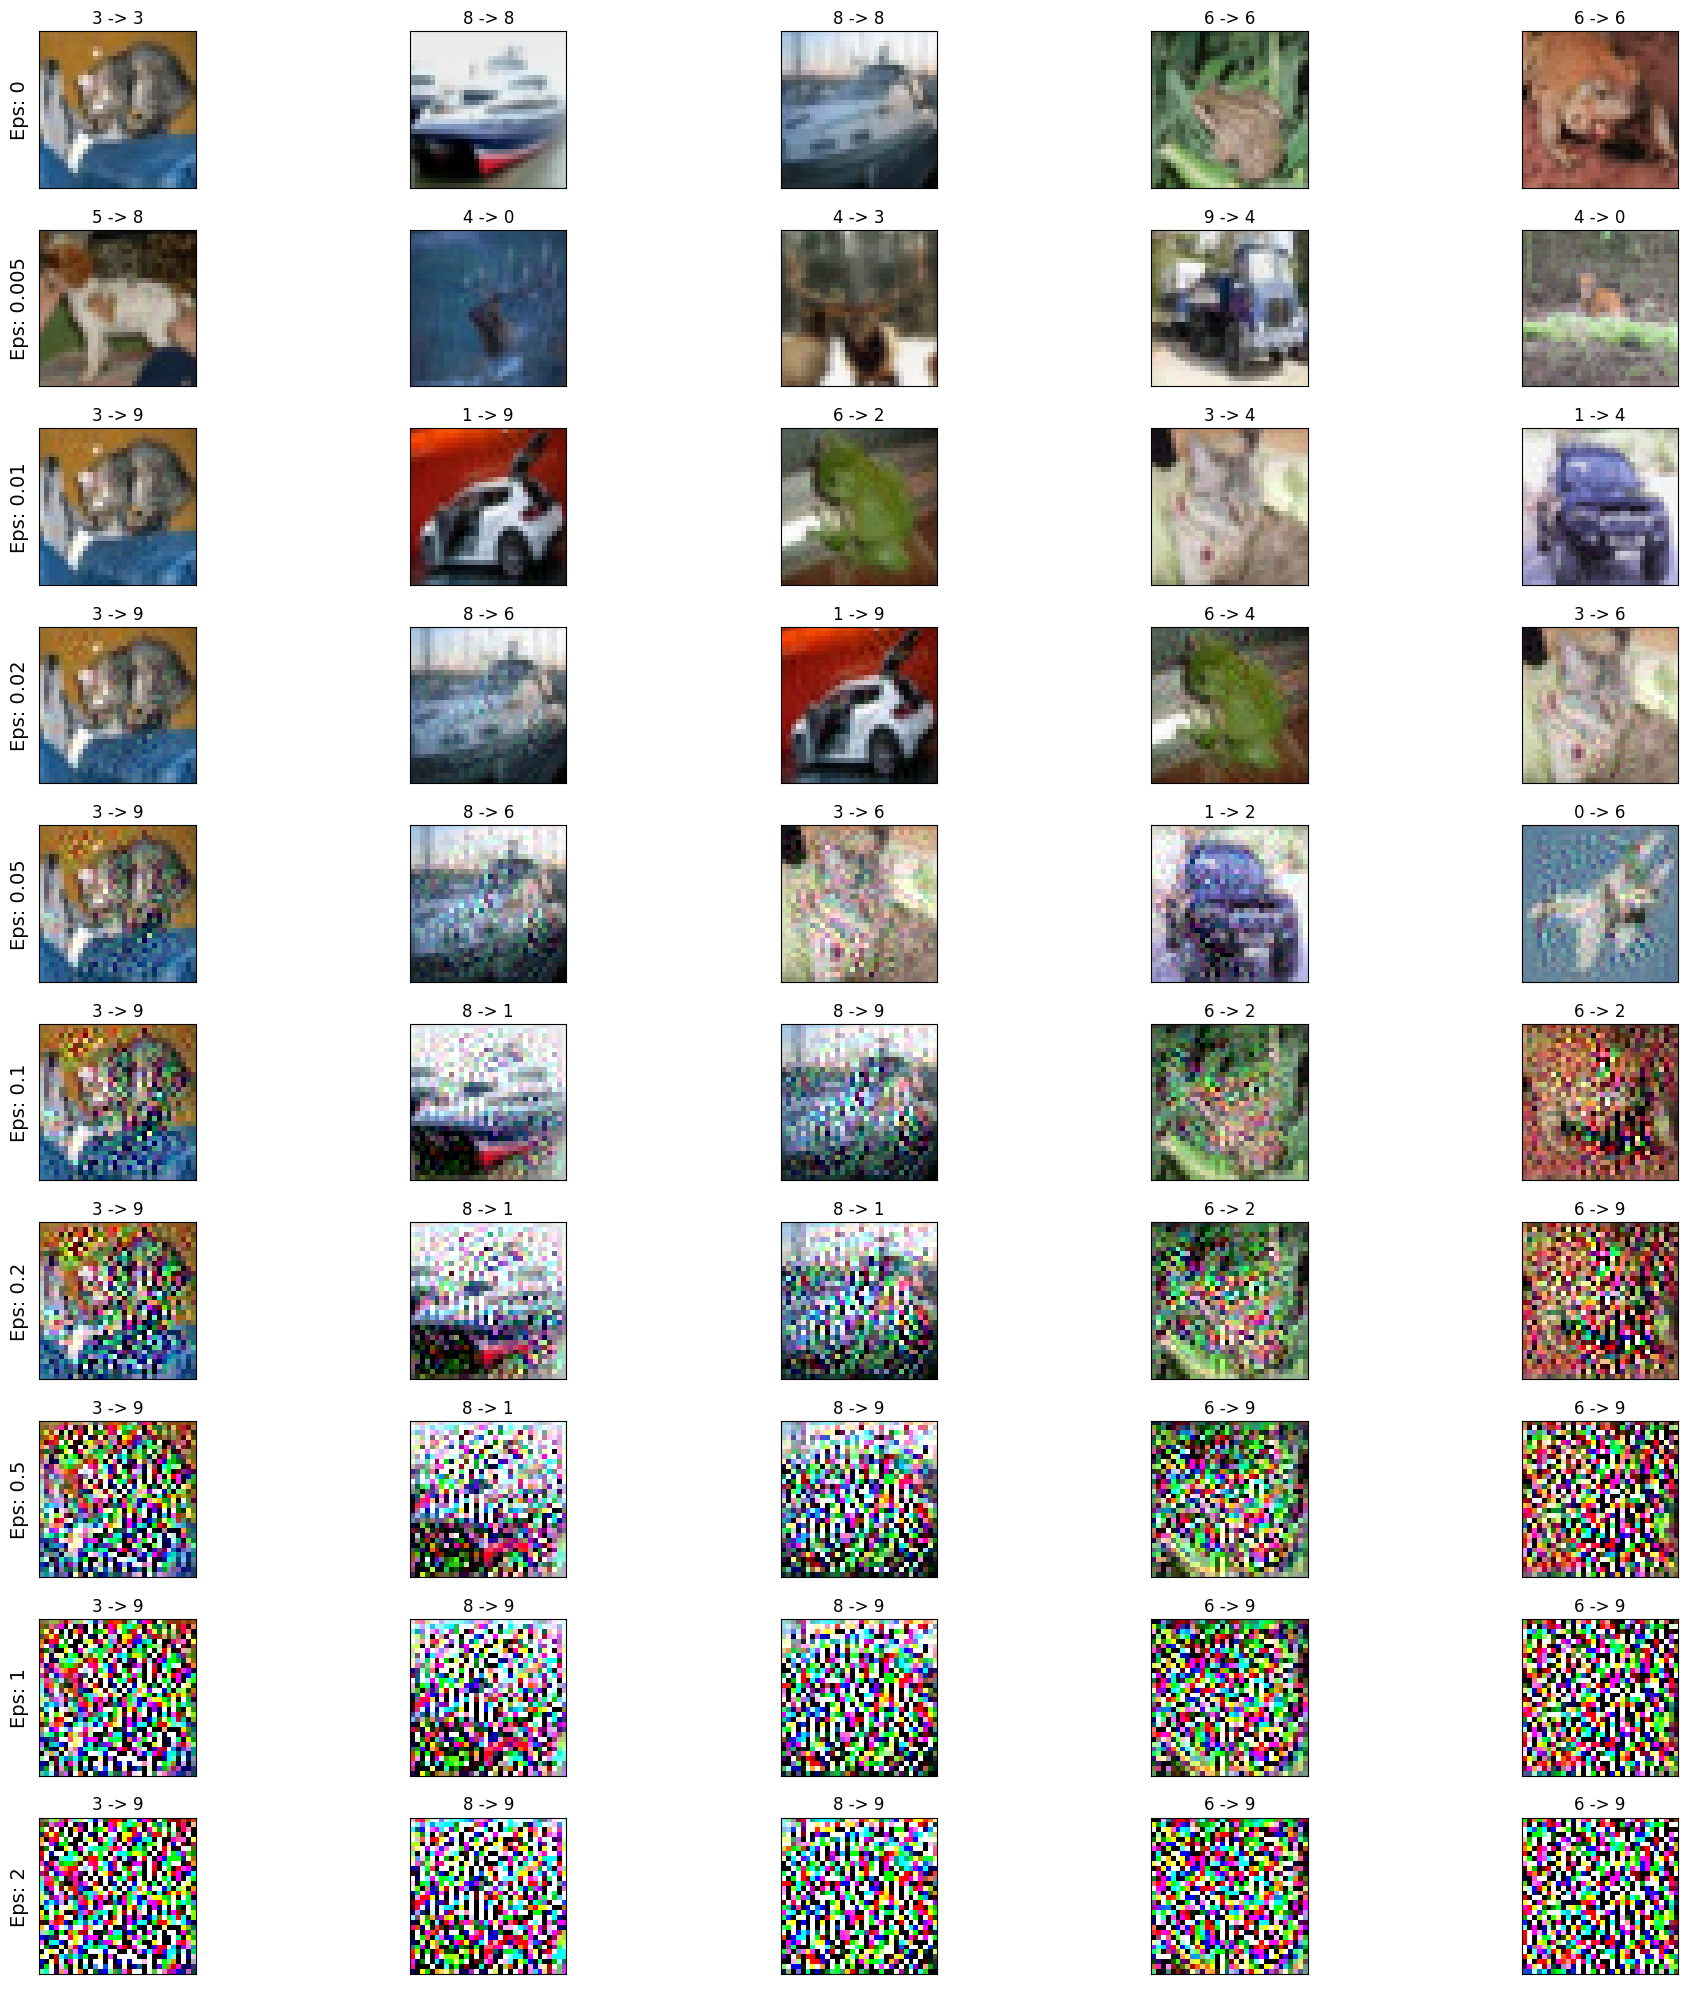

In [12]:
# Display adversarial samples for first attack
display_adv_samples(epsilons, examples)

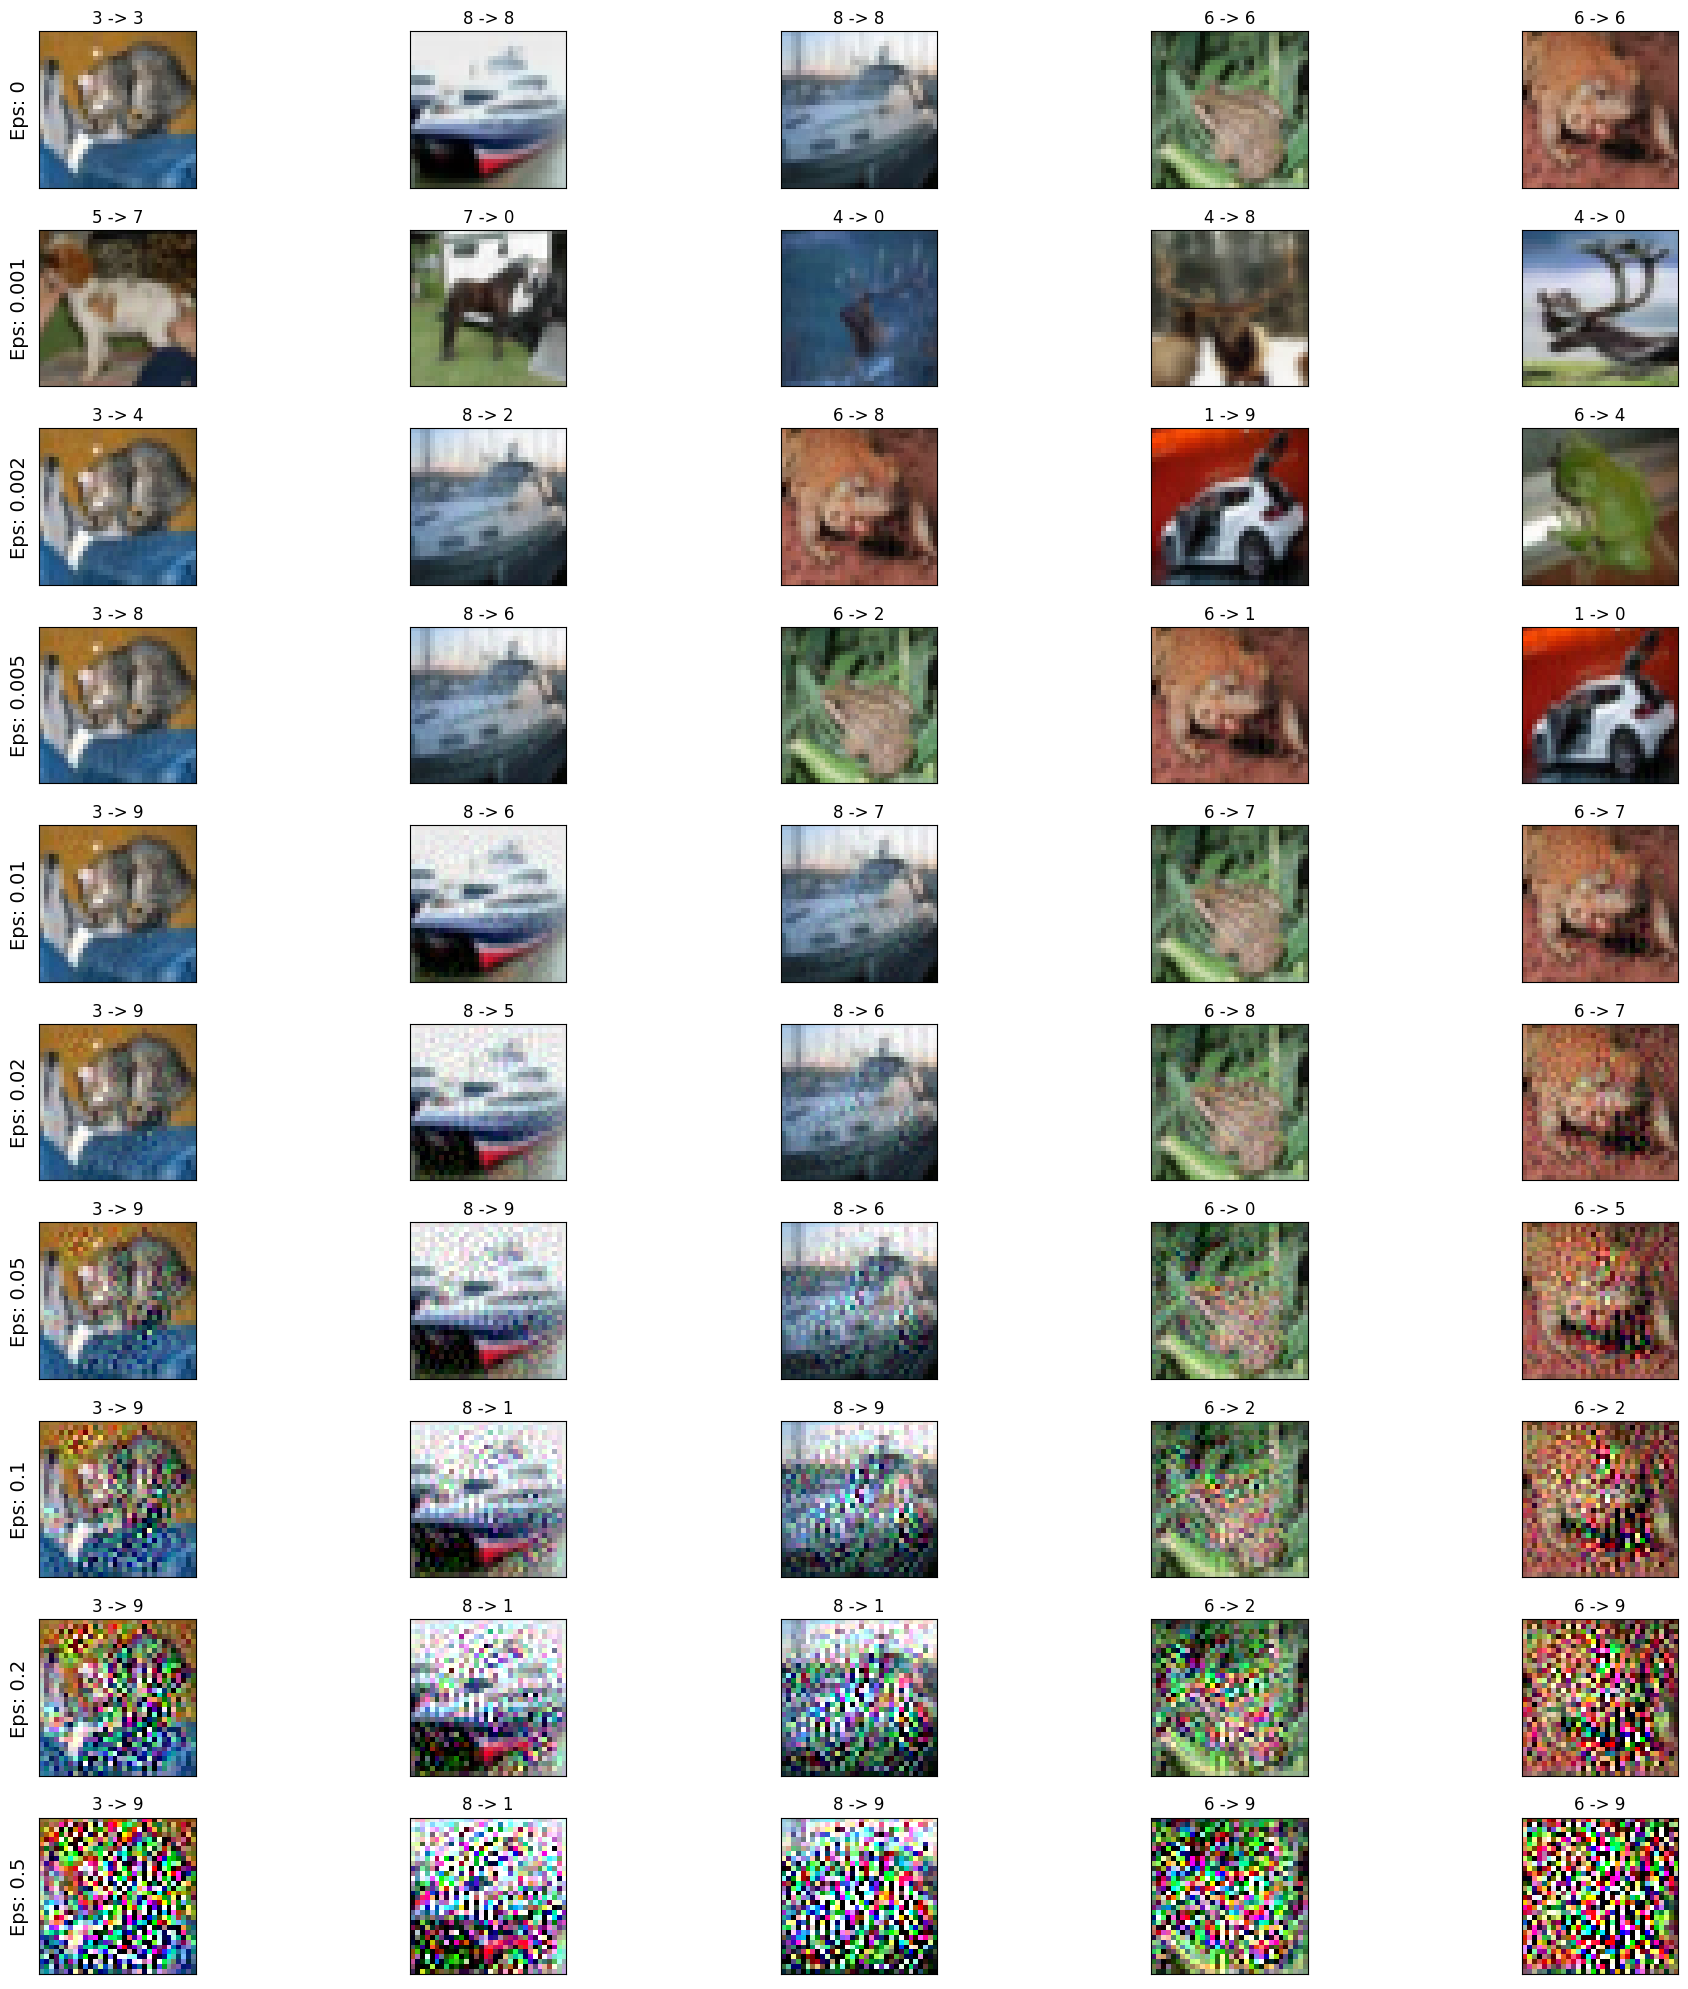

In [13]:
# Display adversarial samples for second attack
display_adv_samples(epsilons2, examples2)

### 6. Creating a surrogate model

Let us now pretend that the original model in Section 2 is protected, using some sort of black-boxing that prevents us from accessing its gradients. This means that using the IUGM attack from earlier on this model directly is therefore forbiden from now on.

Let us create a surrogate version of the model, which has exactly the same architecture, but is not reusing the pre-trained parameters in the resnet.data file.

Below, we show how to create a surrogate model, which uses exactly the same layers as the previous original ResNet model in Section 2, even though with different weights and biases in each of these layers, as it is currently untrained. Is it important that the surrogate follows exactly the same architecture as the original model? Or could we do with a different architecture?

In [14]:
# Make a surrogate version of the model, untrained
surrogate_model = ResNet(ResidualBlock, [2, 2, 2])
surrogate_model.to(device)
surrogate_model.train()
print(surrogate_model)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### 7. Training our surrogate model

We will need to train the surrogate model using the train dataloader from earlier, but also using the outputs of the original model as ground truth, instead of the original labels in the dataset.

In [15]:
def train_surrogate(surrogate_model, original_model, train_loader, epochs = 25, lr = 0.001):
    # Use Adam optimizer to update surrogate model parameters
    optimizer = optim.Adam(surrogate_model.parameters(), lr = lr)
    
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    
    # Performance curves data
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        # Iterate over training data
        for batch_number, (inputs, _) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            
            # Use original model outputs and predictions as ground truth
            orig_outputs = original_model(inputs)
            _, orig_predicted = torch.max(orig_outputs.data, 1)
            
            # Zero out gradients
            optimizer.zero_grad()
            
            # Compute output for surrogate model
            surrog_outputs = surrogate_model(inputs)
            _, surrog_predicted = torch.max(surrog_outputs.data, 1)
            
            # Compute loss for training surrogate
            loss = criterion(surrog_outputs, orig_predicted)
            
            # Backpropagate loss and update surrogate model weights
            loss.backward()
            optimizer.step()
            
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += inputs.size(0)
            correct += (orig_predicted == surrog_predicted).sum().item()
            
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
    
    return train_losses, train_accuracies

We should obtain an accuracy of 97% in the end or so. Does that mean that our surrogate model is better at predicting than the original model, whose baseline accuracy was only 86%?

In [16]:
# Train surrogate from scratch
surrogate_model = ResNet(ResidualBlock, [2, 2, 2])
surrogate_model.to(device)
surrogate_model.train()
train_losses, train_accuracies = train_surrogate(surrogate_model, original_model, \
                                                 train_loader, epochs = 25, lr = 0.001)

--- Epoch 1/25: Train loss: 1.7793, Train accuracy: 0.3353
--- Epoch 2/25: Train loss: 1.4560, Train accuracy: 0.4635
--- Epoch 3/25: Train loss: 1.2644, Train accuracy: 0.5416
--- Epoch 4/25: Train loss: 1.1251, Train accuracy: 0.5942
--- Epoch 5/25: Train loss: 1.0228, Train accuracy: 0.6298
--- Epoch 6/25: Train loss: 0.9186, Train accuracy: 0.6696
--- Epoch 7/25: Train loss: 0.8366, Train accuracy: 0.7015
--- Epoch 8/25: Train loss: 0.7596, Train accuracy: 0.7273
--- Epoch 9/25: Train loss: 0.7055, Train accuracy: 0.7518
--- Epoch 10/25: Train loss: 0.6761, Train accuracy: 0.7563
--- Epoch 11/25: Train loss: 0.6169, Train accuracy: 0.7785
--- Epoch 12/25: Train loss: 0.5190, Train accuracy: 0.8182
--- Epoch 13/25: Train loss: 0.4480, Train accuracy: 0.8489
--- Epoch 14/25: Train loss: 0.3778, Train accuracy: 0.8797
--- Epoch 15/25: Train loss: 0.3541, Train accuracy: 0.8868
--- Epoch 16/25: Train loss: 0.3229, Train accuracy: 0.8970
--- Epoch 17/25: Train loss: 0.3191, Train accura

### 8. Rework your attack to use surrogate, tranfer attack samples to original model

Below we have written the function iugm_attack_surr(), which performs an **untargeted iterated gradient attack**, but using the **surrogate to generate attack samples**, before **testing them on the original (protected) model**.
1. It uses the Option #2, described in class, which - on each iteration of the iterated gradient attack - is aiming towards the least probable class, according to the logits.
2. It has a maximal number of iterations, set to 10 by default.
3. It has 5 inputs:
    - our original image,
    - the epsilon value to be used,
    - the model under attack,
    - the original label for the image,
    - and a maximal number of iterations for the attack.
4. Our attack function simply returns the attack sample to be evaluated by our test function.

Reuse your iugm_attack() function and implement the changes as needed!

In [17]:
def iugm_attack_surr(image, epsilon, original_model, surrogate_model, original_label, iter_num = 10):
    # Skip if epsilon is 0
    if epsilon == 0:
        return image

    for _ in range(iter_num):
        # Zero out previous gradients
        image.grad = None

        # Forward pass
        output = surrogate_model(image)

        # Get the index of the least probable class (min log-probability)
        _, target_class = torch.min(output.data, 1)

        # Calculate loss based on the least probable class
        pred_loss = F.nll_loss(output, target_class)

        # Backward pass and retain graph
        pred_loss.backward(retain_graph = True)

        # Gradient descent to the least probable class (target class)
        eps_image = image - epsilon * image.grad.data
        eps_image.retain_grad()

        # Clipping to maintain pixel values in the [0, 1] range
        eps_image = torch.clamp(eps_image, 0, 1)

        # Forward pass
        new_output = original_model(eps_image)

        # Get prediction
        _, new_label = new_output.data.max(1)

        # Check if label is different from the original, if so stop
        if new_label != original_label:
            break
        else:
            image = eps_image
            image.retain_grad()

    return eps_image

Try your function below. We suggest to use the following $ \epsilon $ values, but feel free to play with them if needed. 

In [18]:
# Test First attack: one-shot untargeted gradient attack
epsilons_surr = [0, .025, .05, .25, 1, 2.5, 5, 10]
accuracies_surr, examples_surr = run_attacks_for_epsilon_surr(epsilons_surr, \
                                                              original_model, \
                                                              surrogate_model, \
                                                              iugm_attack_surr, \
                                                              device, \
                                                              test_loader, \
                                                              max_iter = 1)

Epsilon: 0 - Model Accuracy (under attack) = 176/200 = 0.88
Epsilon: 0.025 - Model Accuracy (under attack) = 174/200 = 0.87
Epsilon: 0.05 - Model Accuracy (under attack) = 172/200 = 0.86
Epsilon: 0.25 - Model Accuracy (under attack) = 139/200 = 0.695
Epsilon: 1 - Model Accuracy (under attack) = 56/200 = 0.28
Epsilon: 2.5 - Model Accuracy (under attack) = 21/200 = 0.105
Epsilon: 5 - Model Accuracy (under attack) = 17/200 = 0.085
Epsilon: 10 - Model Accuracy (under attack) = 19/200 = 0.095


In [19]:
# Test Second attack: iterated untargeted gradient attack
epsilons_surr2 = [0, .005, .01, .05, .1, .2, .5, 1, 2, 5]
accuracies_surr2, examples_surr2 = run_attacks_for_epsilon_surr(epsilons_surr2, \
                                                                original_model, \
                                                                surrogate_model, \
                                                                iugm_attack_surr, \
                                                                device, \
                                                                test_loader, \
                                                                max_iter = 10)

Epsilon: 0 - Model Accuracy (under attack) = 176/200 = 0.88
Epsilon: 0.005 - Model Accuracy (under attack) = 175/200 = 0.875
Epsilon: 0.01 - Model Accuracy (under attack) = 174/200 = 0.87
Epsilon: 0.05 - Model Accuracy (under attack) = 164/200 = 0.82
Epsilon: 0.1 - Model Accuracy (under attack) = 138/200 = 0.69
Epsilon: 0.2 - Model Accuracy (under attack) = 99/200 = 0.495
Epsilon: 0.5 - Model Accuracy (under attack) = 50/200 = 0.25
Epsilon: 1 - Model Accuracy (under attack) = 26/200 = 0.13
Epsilon: 2 - Model Accuracy (under attack) = 9/200 = 0.045
Epsilon: 5 - Model Accuracy (under attack) = 6/200 = 0.03


### 9. Final visualization for surrogate attack

As before, let us compare the attack curves of our attacks effects on both models.

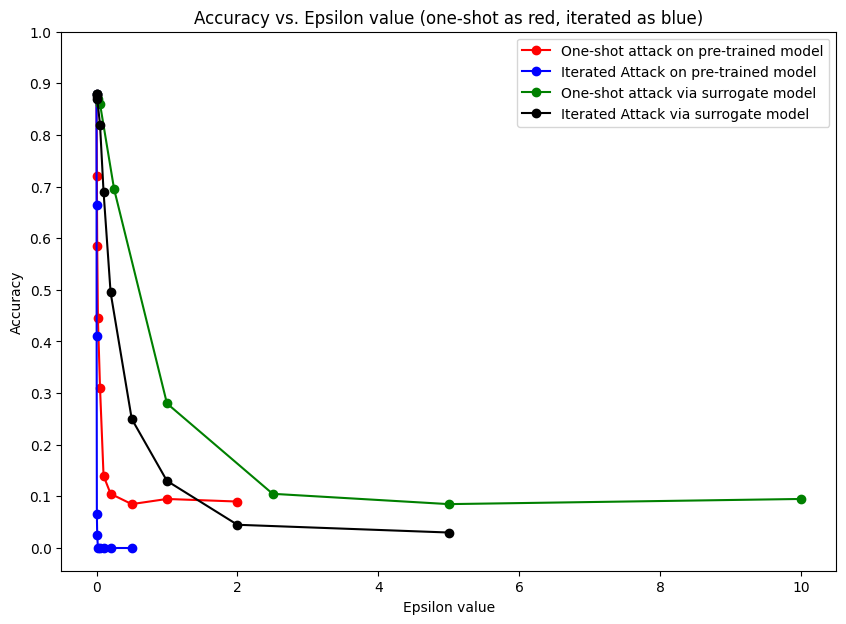

In [20]:
# Show attack curves for original attack and surrogate attack
display_attack_curves_surr(epsilons, epsilons2, \
                           accuracies, accuracies2, \
                           epsilons_surr, accuracies_surr, \
                           epsilons_surr2, accuracies_surr2)

Skipped value eps = 0.025, did not have 5 samples to display
Skipped value eps = 0.05, did not have 5 samples to display


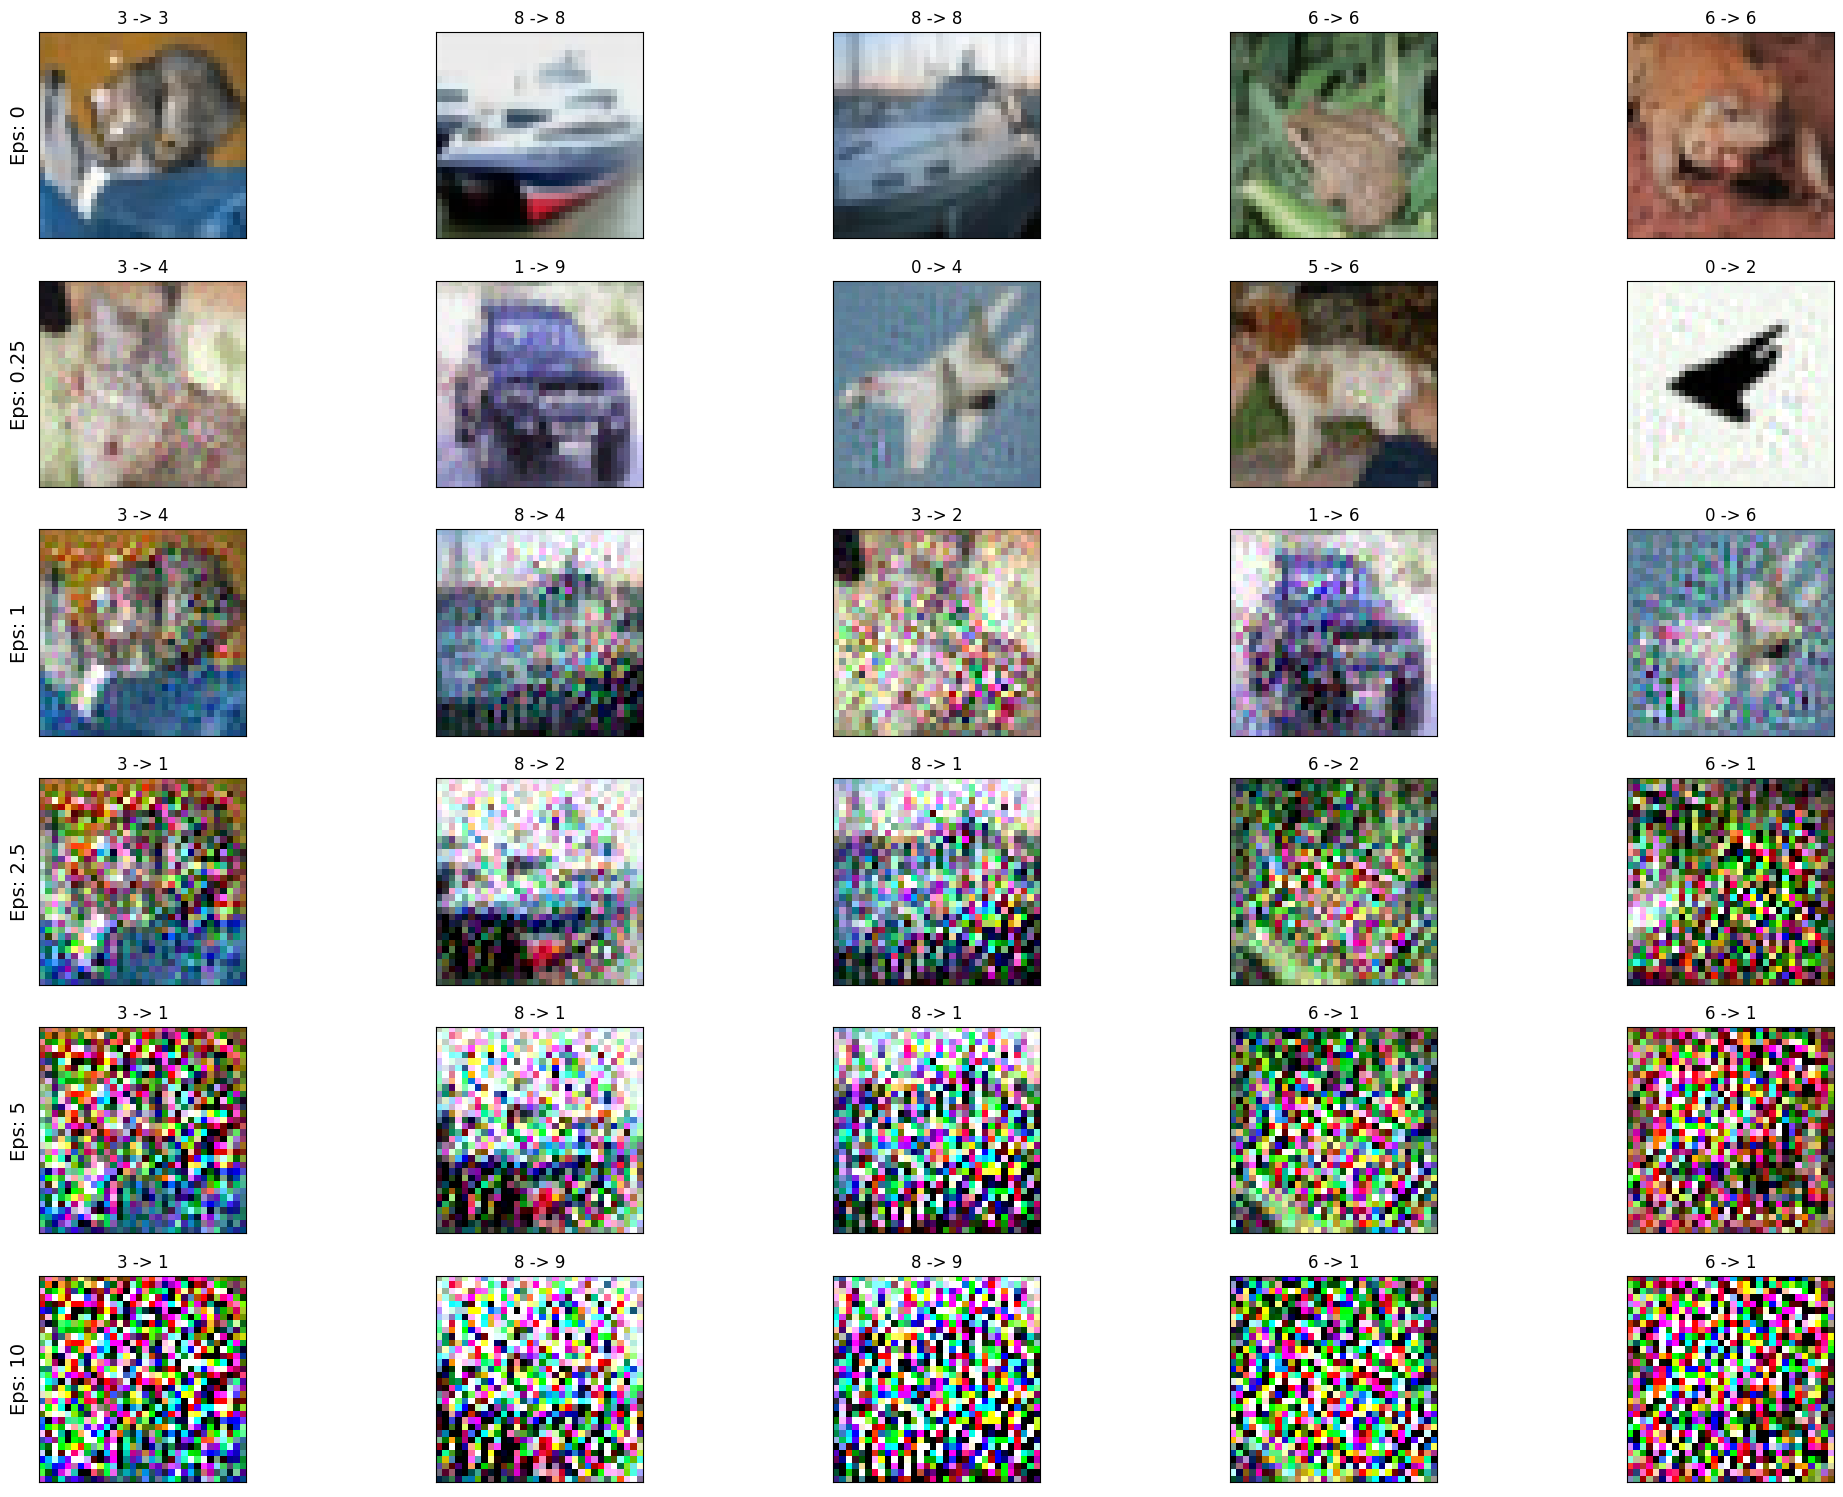

In [21]:
# Display adversarial samples for first attack on surrogate
display_adv_samples(epsilons_surr, examples_surr)

Skipped value eps = 0.005, did not have 5 samples to display
Skipped value eps = 0.01, did not have 5 samples to display


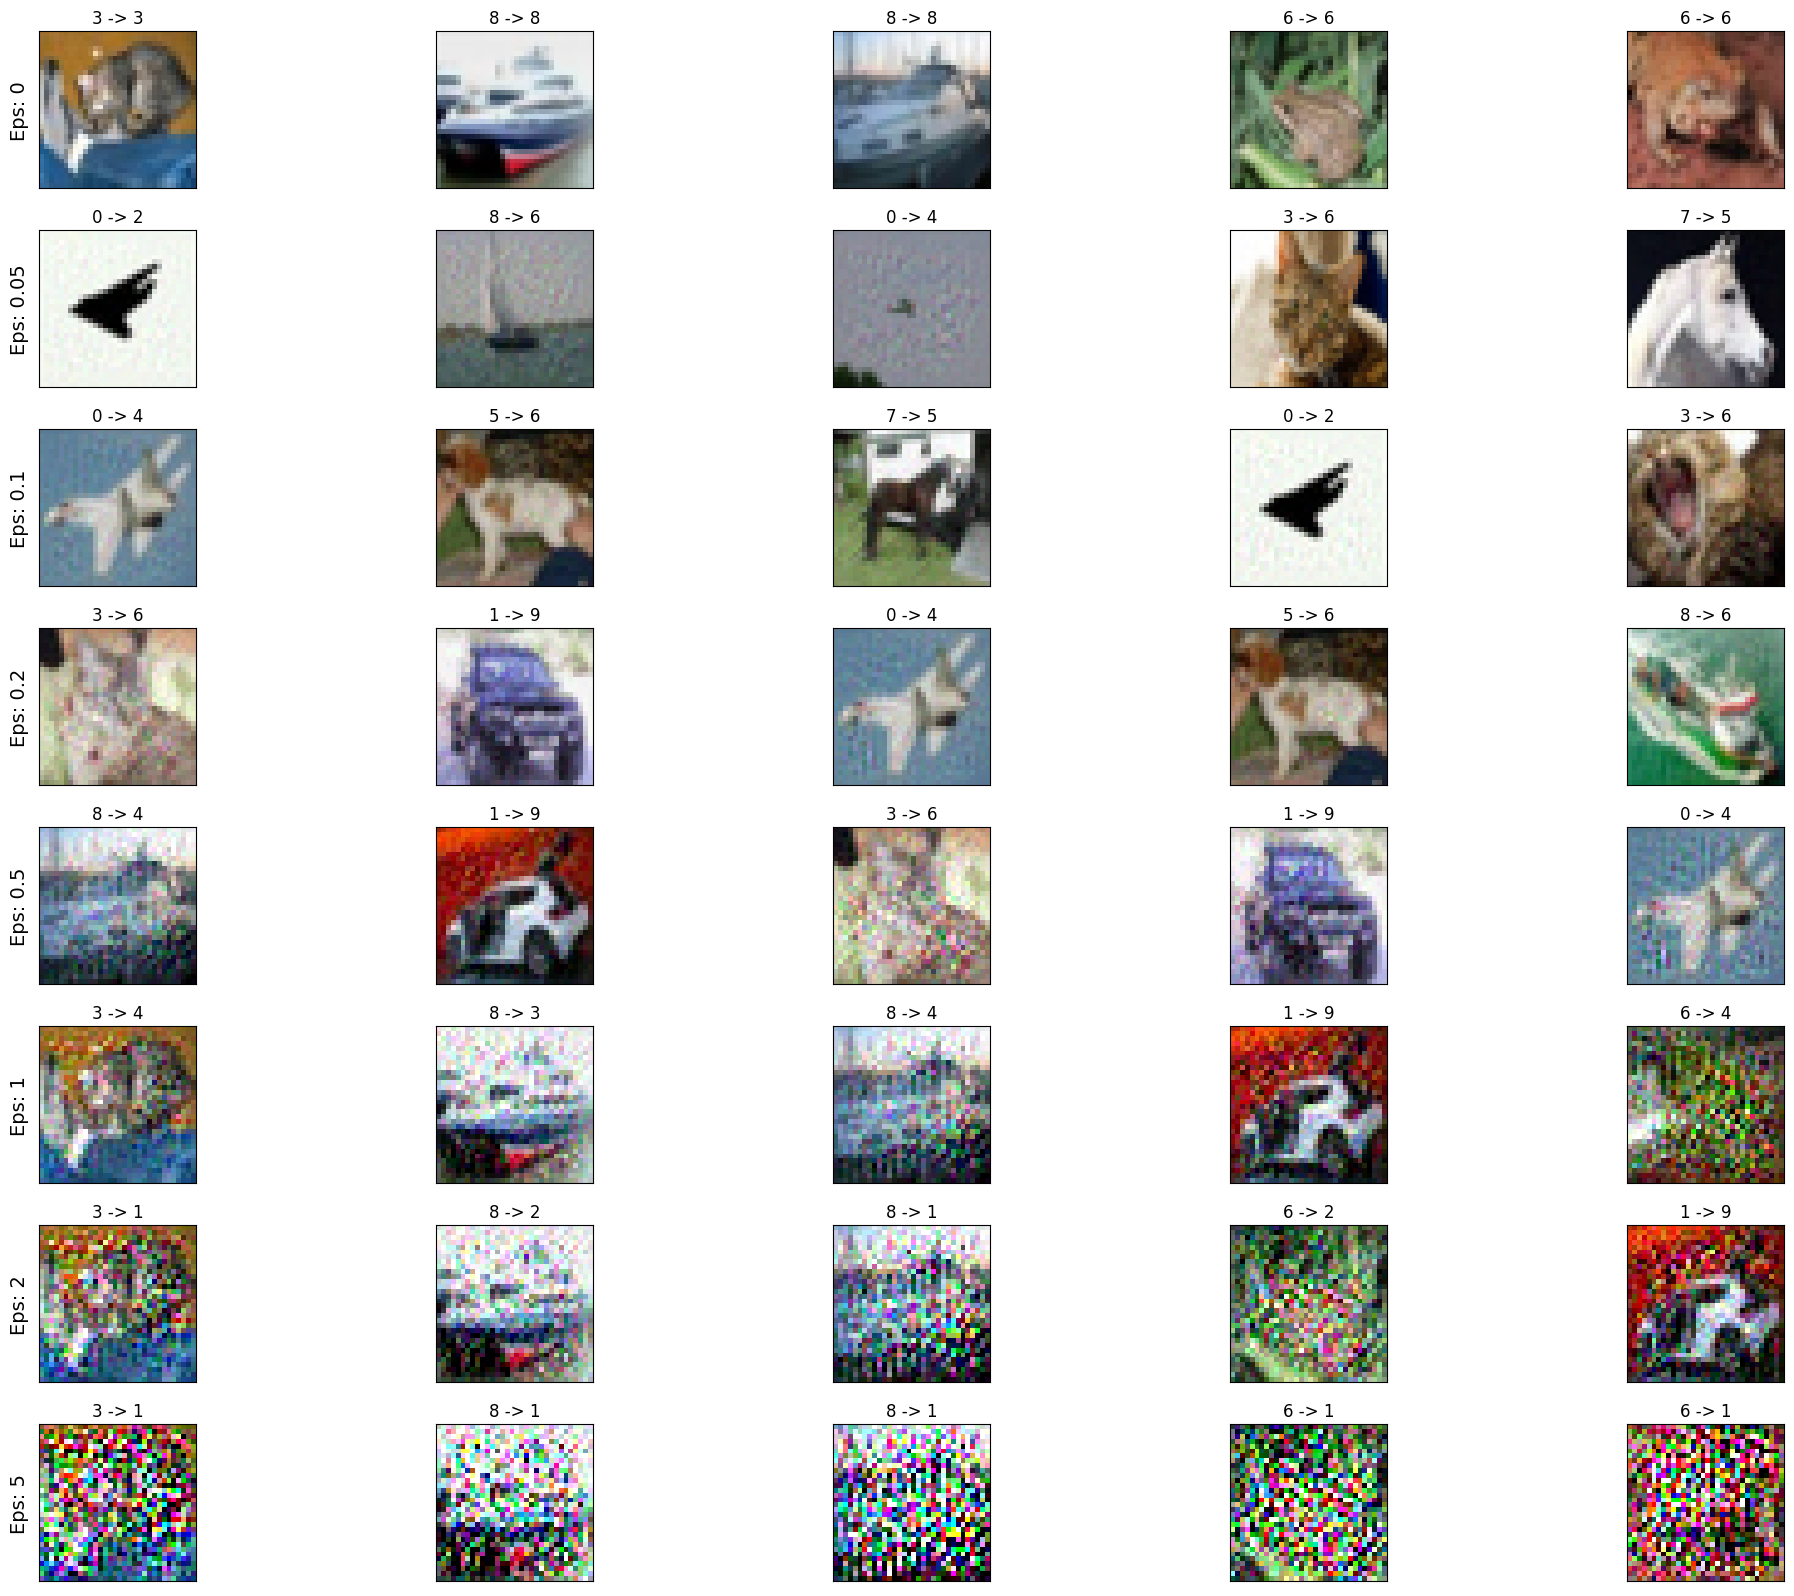

In [22]:
# Display adversarial samples for second attack on surrogate
display_adv_samples(epsilons_surr2, examples_surr2)

### Challenge questions

**Challenge:** Can you suggest directions to improve the performance of our surrogate attack even more? Implementing these operations is not required.

<div class="alert alert-danger">
    At the moment, the best course of action is to try and make the surrogate model match the original model as much as possible: 97% was good, but there should be a way to achieve 100% using more iterations of training and by playing on the learning rate.
    This is possibly the safest direction, which could lead to improvements in terms of attack performance.
    Adding a plausibility contraint, or allowing for more than 10 iterations in our surrogate attack function could also lead to better attack samples.
    Both of these approaches are worth trying.
    Suggesting to use other attack methods like boundary, Carlini-Wagner is not exactly an acceptable answer as it would not even require to train a surrogate in the first place.
</div>